# SI 370: Correlation and Regression

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [45]:
evals = pd.read_csv('https://raw.githubusercontent.com/umsi-data-science/data/main/evals.csv')
evals.head()

,ID,prof_ID,score,age,bty_avg,gender,ethnicity,language,rank,pic_outfit,pic_color,cls_did_eval,cls_students,cls_level
0,1,1,4.7,36,5.0,female,minority,english,tenure track,not formal,color,24,43,upper
1,2,1,4.1,36,5.0,female,minority,english,tenure track,not formal,color,86,125,upper
2,3,1,3.9,36,5.0,female,minority,english,tenure track,not formal,color,76,125,upper
3,4,1,4.8,36,5.0,female,minority,english,tenure track,not formal,color,77,123,upper
4,5,2,4.6,59,3.0,male,not minority,english,tenured,not formal,color,17,20,upper


In [10]:
evals = evals[['score','age','bty_avg']]

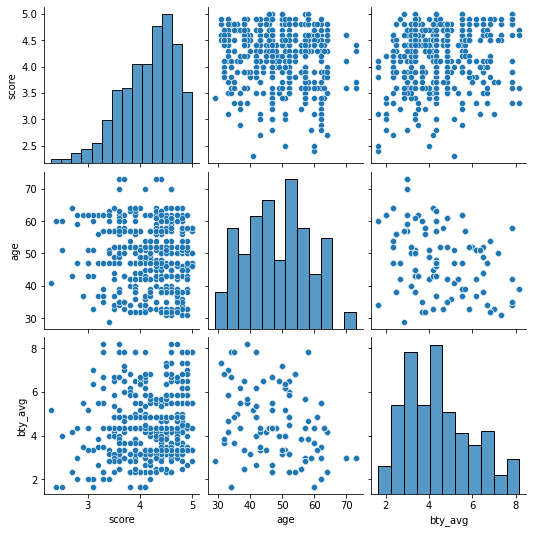

In [11]:
sns.pairplot(evals)

In [12]:
# to calculate all possible correlation coefficients in a dataframe
evals.corr()

,score,age,bty_avg
score,1.000000,-0.107032,0.187142
age,-0.107032,1.000000,-0.304603
bty_avg,0.187142,-0.304603,1.000000


A heatmap is a really useful visualization technique for large correlation matrices (less so for small correlation matrices:

<AxesSubplot:>

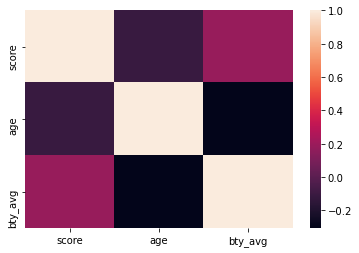

In [14]:
sns.heatmap(evals.corr())

We can also use a different type of color palette to highlight the differences:

<AxesSubplot:>

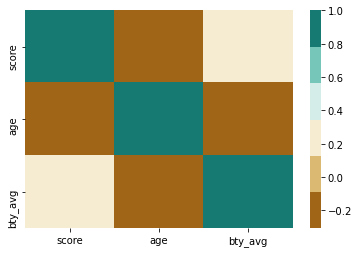

In [15]:
sns.heatmap(evals.corr(),cmap=sns.color_palette("BrBG"))

We can also create a more complex visualization that incorporates
histograms of each variable as well as a scatterplot with a
regression line including confidence intervals.

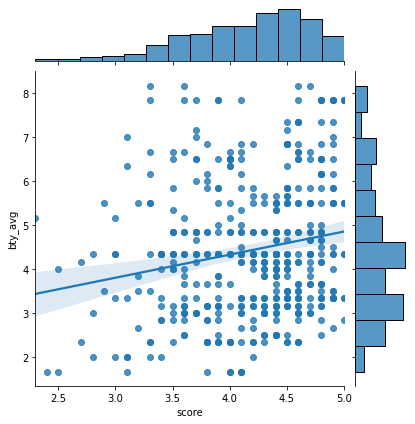

In [23]:
g = sns.JointGrid(data=evals,x='score',y='bty_avg')
g = g.plot(sns.regplot, sns.histplot)

## Ordinary Least Squares (OLS) Regression

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

statsmodels uses R-Style formulas: y ~ x1 + x2 + x3 + ...

1. y represents the outcome/dependent variable
2. x1, x2, x3, etc represent explanatory/independent variables 

In [46]:
model0 = smf.ols("score ~ bty_avg", data=evals).fit()
model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     16.73
Date:                Wed, 11 Nov 2020   Prob (F-statistic):           5.08e-05
Time:                        13:19:47   Log-Likelihood:                -366.22
No. Observations:                 463   AIC:                             736.4
Df Residuals:                     461   BIC:                             744.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.8803      0.076     50.961      0.000       3.731       4.030
bty_avg        0.0666      0.016      4.090      0.000       0.035       0.099
==============================================================================
Omnibus:                       33.007   Durbin-Watson:                   1.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.797
Skew:                          -0.709   Prob(JB):                     3.76e-09
Kurtosis:                       3.007   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:ylabel='Count'>

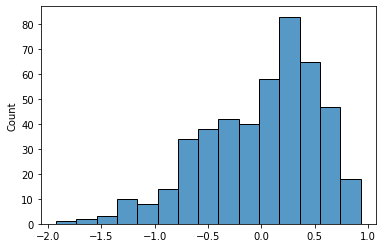

In [61]:
sns.histplot(model0.resid)

<AxesSubplot:xlabel='bty_avg'>

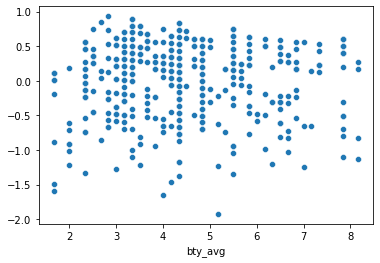

In [62]:
sns.scatterplot(x=evals['bty_avg'],y=model0.resid)

In [47]:
model0.params

Intercept    3.880338
bty_avg      0.066637
dtype: float64

In [48]:
model0.params.loc['bty_avg']

0.06663703701981423

In [55]:
model0.conf_int()

,0,1
Intercept,3.730708,4.029968
bty_avg,0.034623,0.098651


In [50]:
# Bootstrapping the slope
evals_sample = evals.sample(n=len(evals),replace=True)
evals_sample.head()

,ID,prof_ID,score,age,bty_avg,gender,ethnicity,language,rank,pic_outfit,pic_color,cls_did_eval,cls_students,cls_level
262,263,49,4.8,52,3.167,male,not minority,english,tenured,not formal,color,27,30,upper
45,46,9,4.7,33,4.667,female,not minority,english,tenure track,not formal,color,29,49,upper
102,103,19,5.0,46,4.333,female,not minority,english,tenured,not formal,black&white,14,15,lower
98,99,18,4.3,48,4.333,male,not minority,english,teaching,not formal,color,18,27,upper
151,152,27,3.6,52,4.833,male,minority,non-english,tenured,formal,color,12,15,upper


In [42]:
nreps = 1000
slopes = []
for i in range(nreps):
    evals_sample = evals.sample(n=len(evals),replace=True)
    model = smf.ols("score ~ bty_avg", data=evals_sample).fit()
    slope = model.params.loc['bty_avg']
    slopes.append(slope)
mean = np.mean(slopes)
sd = np.std(slopes)
print(mean,sd)

0.06665916983697312 0.017194621143857183


In [59]:
lower_percentile = np.quantile(slopes,0.025)
upper_percentile = np.quantile(slopes,0.975)

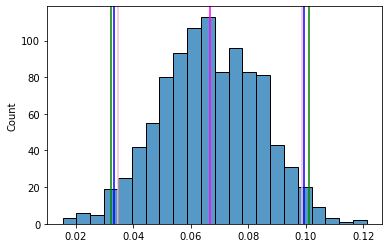

In [60]:
ax = sns.histplot(slopes)
ax.axvline(mean,color='magenta')
ax.axvline(mean-2*sd,color='green')
ax.axvline(mean+2*sd,color='green')
ax.axvline(model0.conf_int().loc['bty_avg'].iloc[0],color='pink')
ax.axvline(model0.conf_int().loc['bty_avg'].iloc[1],color='pink')
ax.axvline(np.quantile(slopes,0.025),color='blue')
ax.axvline(np.quantile(slopes,0.975),color='blue')

Let's look at Anscombe's Quartet:

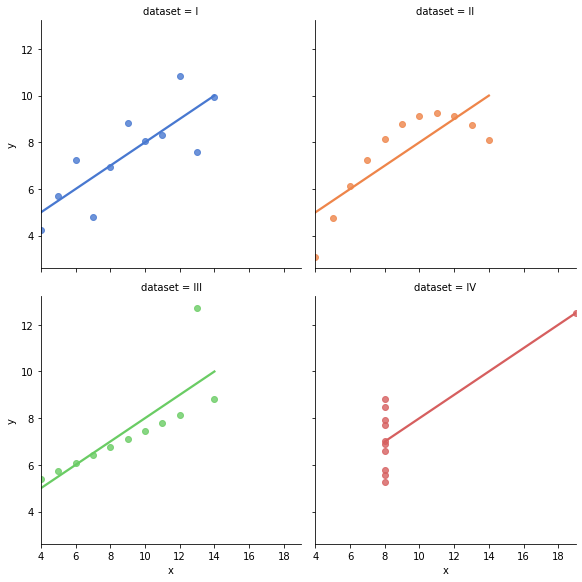

In [94]:
anscombe = sns.load_dataset("anscombe")

# Show the results of a linear regression within each dataset
sns.lmplot(x="x", y="y", col="dataset", hue="dataset", data=anscombe,
           col_wrap=2, ci=None, palette="muted", height=4)

In [97]:
anscombe.sample(10)


,dataset,x,y
7,I,4.0,4.26
29,III,4.0,5.39
5,I,14.0,9.96
28,III,6.0,6.08
37,IV,8.0,8.47
15,II,11.0,9.26
31,III,7.0,6.42
41,IV,8.0,5.56
36,IV,8.0,8.84
39,IV,8.0,5.25


In [33]:
anscombe_1 = anscombe[anscombe.dataset == 'I']
anscombe_2 = anscombe[anscombe.dataset == 'II']
anscombe_3 = anscombe[anscombe.dataset == 'III']
anscombe_4 = anscombe[anscombe.dataset == 'IV']

The rsquared value is 0.6665424595087751


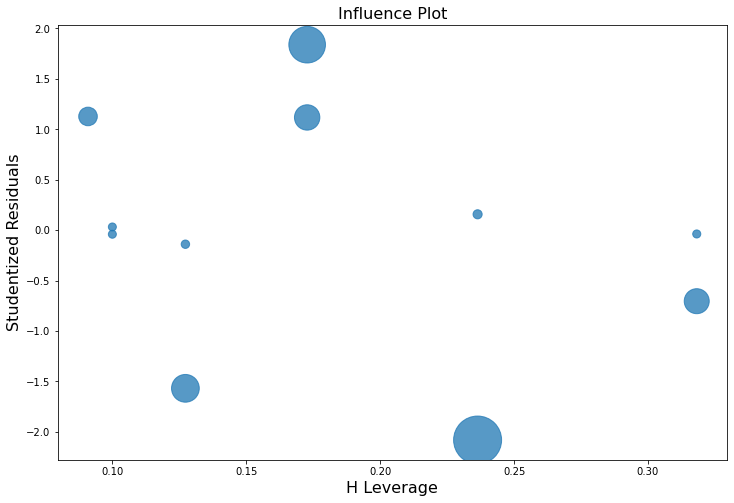

In [98]:
anscombe_1_lm = smf.ols('y ~ x',anscombe_1).fit()
print("The rsquared value is " + str(anscombe_1_lm.rsquared))
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(anscombe_1_lm, ax= ax, criterion="cooks",alpha=0.05)
                                     
                                     

The rsquared value is 0.6662420337274844


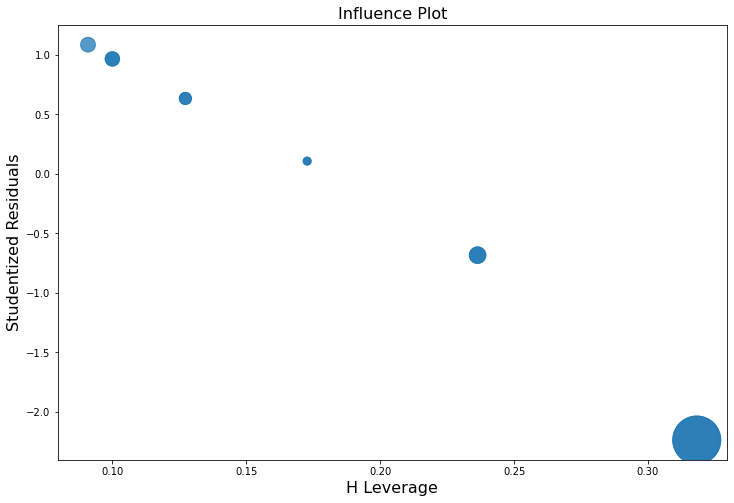

In [99]:
anscombe_2_lm = smf.ols('y ~ x',anscombe_2).fit()
print("The rsquared value is " + str(anscombe_2_lm.rsquared))
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(anscombe_2_lm, ax= ax, criterion="cooks",alpha=.05)
                                     
                                     

The rsquared value is 0.6663240410665592


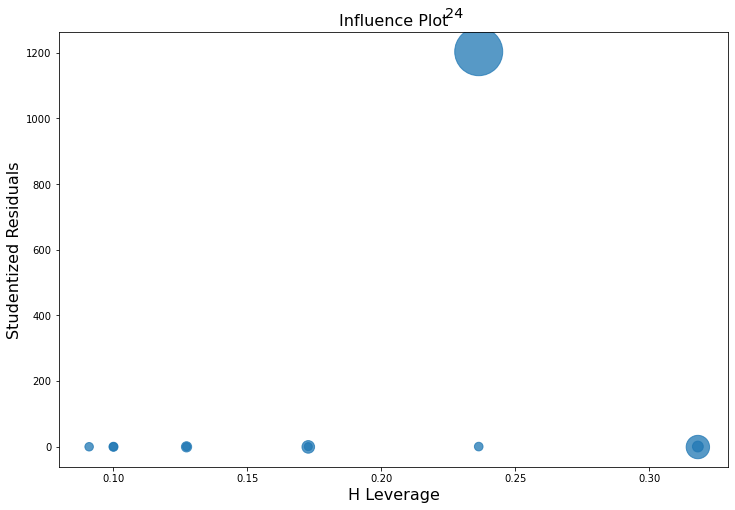

In [100]:
anscombe_3_lm = smf.ols('y ~ x',anscombe_3).fit()
print("The rsquared value is " + str(anscombe_3_lm.rsquared))
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(anscombe_3_lm, ax= ax, criterion="cooks",alpha=0.05)
                                     
                                     

In [101]:
anscombe_4.head(10)

,dataset,x,y
33,IV,8.0,6.58
34,IV,8.0,5.76
35,IV,8.0,7.71
36,IV,8.0,8.84
37,IV,8.0,8.47
38,IV,8.0,7.04
39,IV,8.0,5.25
40,IV,19.0,12.50
41,IV,8.0,5.56
42,IV,8.0,7.91


The rsquared value is 0.6667072568984653


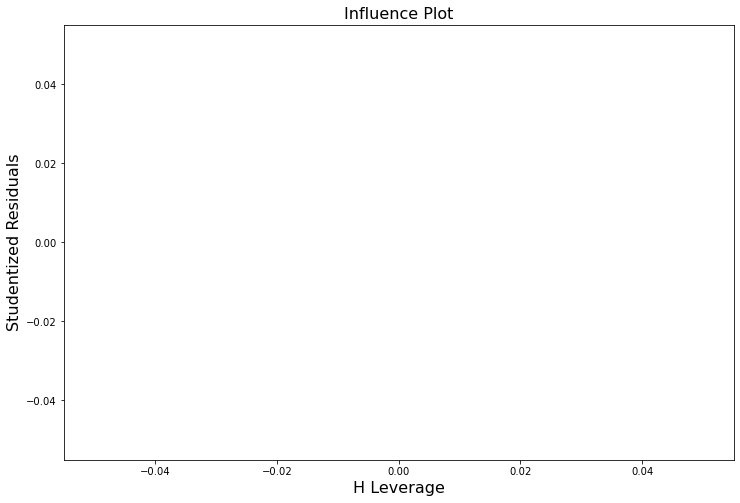

In [102]:
anscombe_4_lm = smf.ols('y ~ x',anscombe_4).fit()
print("The rsquared value is " + str(anscombe_4_lm.rsquared))
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(anscombe_4_lm, ax= ax, criterion="cooks",alpha=0.05)
                                     
                                     

In [103]:
infl = anscombe_3_lm.get_influence()
sm_fr = infl.summary_frame()
sm_fr

,dfb_Intercept,dfb_x,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
22,-0.004626,-4.412673e-02,0.011765,-0.460177,0.100000,-0.153392,-0.439055,-0.146352
23,-0.037133,1.864368e-02,0.002141,-0.196333,0.100000,-0.065444,-0.185502,-0.061834
24,-357.909597,5.252677e+02,1.392849,2.999992,0.236364,1.669041,1203.539464,669.587544
25,-0.032900,-1.340142e-15,0.005473,-0.330851,0.090909,-0.104624,-0.313844,-0.099246
26,0.049155,-1.172274e-01,0.025984,-0.596951,0.127273,-0.227964,-0.574295,-0.219312
27,0.489742,-6.674064e-01,0.300571,-1.134972,0.318182,-0.775333,-1.155982,-0.789686
28,0.027001,-2.088417e-02,0.000518,0.070416,0.172727,0.032176,0.066407,0.030344
29,0.240903,-2.089150e-01,0.033817,0.380699,0.318182,0.260067,0.361851,0.247192
30,0.137434,-2.313597e-01,0.059536,-0.755177,0.172727,-0.345068,-0.735677,-0.336158
31,-0.019702,1.342485e-02,0.000355,-0.069739,0.127273,-0.026632,-0.065768,-0.025116


We can also extract the Cook's Distance values and their associated p-values from the influence object:

In [104]:
c,p = infl.cooks_distance

and create a DataFrame with the results

In [105]:
df = pd.DataFrame.from_dict({'cooks_distance':c,'pvalue':p})
df

,cooks_distance,pvalue
0,0.011765,0.988319
1,0.002141,0.997861
2,1.392849,0.297161
3,0.005473,0.994545
4,0.025984,0.974424
5,0.300571,0.747547
6,0.000518,0.999483
7,0.033817,0.966870
8,0.059536,0.942570
9,0.000355,0.999645


Note that we could sort the above in various, helpful ways.

### Q4: Create an influence plot for the regression of "total sulfur dioxide" vs. "free sulfur dioxide".  

Visually identify outliers.



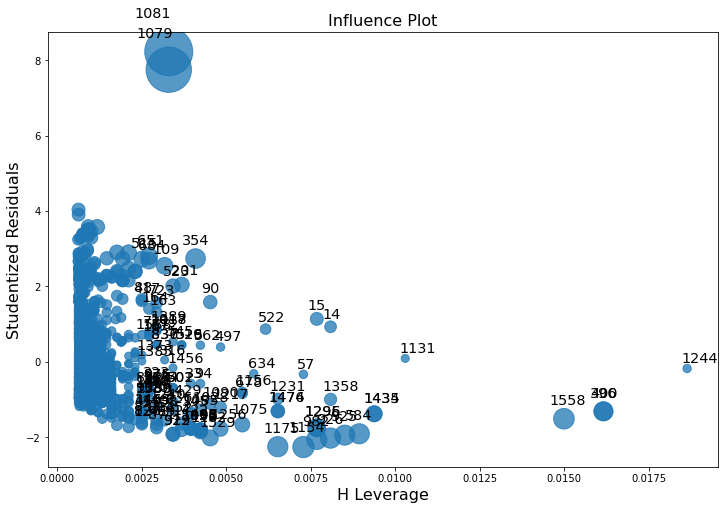

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model2, ax=ax, criterion="Cooks",alpha=0.0000005)

### Q5: How many influence points are there, according to statistically significant Cook's distances?


In [44]:
infl = model2.get_influence()
sm_fr = infl.summary_frame()
sm_fr


,dfb_Intercept,dfb_Q('free sulfur dioxide'),cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.002141,0.001063,0.000003,-0.091146,0.000761,-0.002516,-0.091118,-0.002515
1,-0.000250,0.001224,0.000002,0.056052,0.001102,0.001861,0.056035,0.001861
2,0.005932,-0.000801,0.000046,0.382588,0.000630,0.009604,0.382485,0.009602
3,0.005250,0.001227,0.000066,0.456115,0.000633,0.011476,0.456002,0.011473
4,-0.002141,0.001063,0.000003,-0.091146,0.000761,-0.002516,-0.091118,-0.002515
...,...,...,...,...,...,...,...,...
1594,0.027424,-0.057327,0.002332,-1.484427,0.002113,-0.068300,-1.484987,-0.068326
1595,0.058533,-0.099824,0.005993,-1.800414,0.003684,-0.109479,-1.801680,-0.109556
1596,0.017335,-0.043682,0.001559,-1.390127,0.001611,-0.055835,-1.390533,-0.055851
1597,0.027424,-0.057327,0.002332,-1.484427,0.002113,-0.068300,-1.484987,-0.068326


In [45]:
p,c = infl.cooks_distance
df = pd.DataFrame.from_dict({'cooks_distance':c,'pvalue':p})
df

,cooks_distance,pvalue
0,0.999997,0.000003
1,0.999998,0.000002
2,0.999954,0.000046
3,0.999934,0.000066
4,0.999997,0.000003
...,...,...
1594,0.997670,0.002332
1595,0.994025,0.005993
1596,0.998442,0.001559
1597,0.997670,0.002332


Insert your answer here.

In [46]:
df.sort_values('cooks_distance')

,cooks_distance,pvalue
1081,0.898036,1.075528e-01
1079,0.908574,9.588442e-02
1154,0.981459,1.871485e-02
1558,0.982791,1.735861e-02
926,0.983476,1.666267e-02
...,...,...
194,1.000000,2.499602e-08
193,1.000000,2.499602e-08
117,1.000000,2.499602e-08
816,1.000000,3.685543e-09
